# Подготовка данных

По причине нечитаемости файла wiki.en.vec под Windows, этот файл был отфильтрован на другой машине и результата выполнения здесь не будет. Соответственно данные лежат в отфильтрованном файле data.txt. Сначала загрузим данные и преобразуем в формат numpy.array.

In [1]:
import numpy as np
from scipy.cluster.vq import kmeans2
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans

In [5]:
data = list(open('data.txt').read().split('\n'))
a = len(data)
traindata = []
for j in range(a):
    i = a - j - 1
    if data[i] is not '': 
        data[i] = data[i].split(' ')
        traindata.append(data[i][1:-1])
    else:
        data.pop(i)
traindata = np.array(traindata, dtype=np.float)

# Анализ данных

Посмотрев на гистограммы и средние можно сказать, что распределине близко к нормальному, но тем не менее отклонение от 
выборочного среднего достигает 0.25, тем не менее общее среднее очень близо к 0.

(19924, 300)
-0.045342032386438476


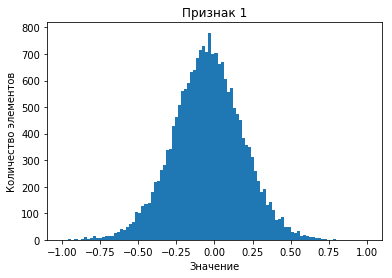

-0.02935998801816904


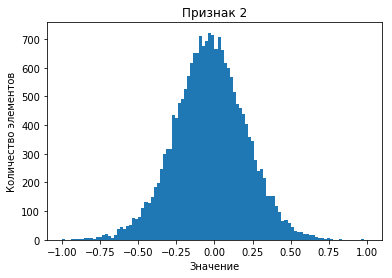

-0.1540862898480225


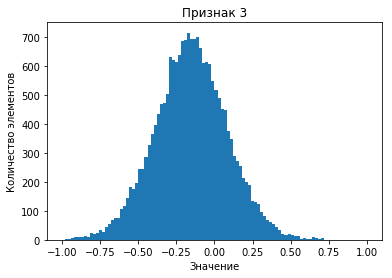

0.16802282231500706


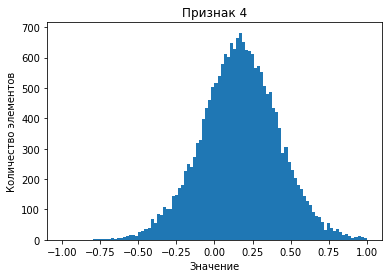

-0.1206643013014706


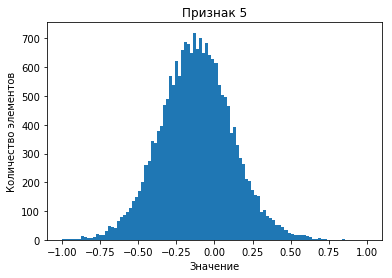

0.016813838235580206


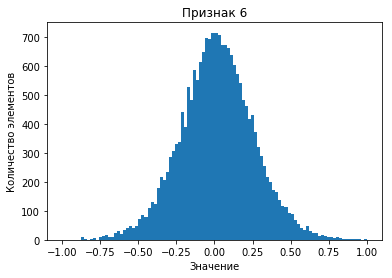

0.06415388072400122


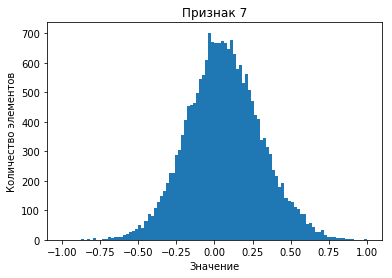

-0.14503732678528405


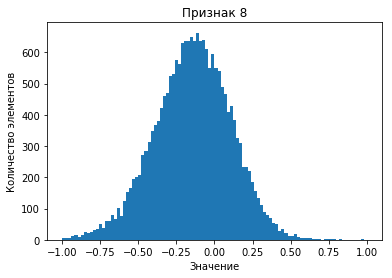

-0.0020340770753864684


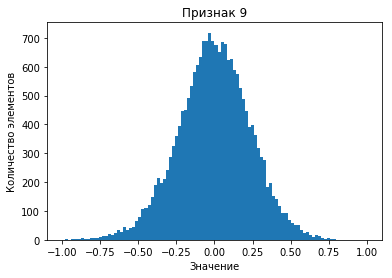

0.10622762763165026


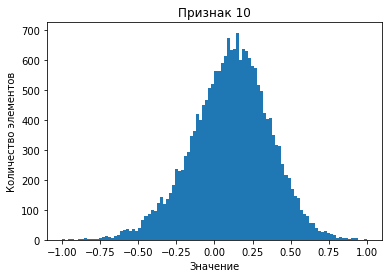

In [31]:
print(traindata.shape)

for i in range(10):
    print(np.mean(traindata[:, i]))
    plt.hist(traindata[:, i], bins=100, range=(-1, 1))
    plt.title("Признак {}".format(i+1))
    plt.xlabel("Значение")
    plt.ylabel("Количество элементов")
    plt.show()

# Эксперимент

В результате эксперимента хотлесь бы оценить точность кластеризации для различных К алгоритмом K-means. Так же хотелось бы определить оптимальное количество кластеров.

In [9]:
a = len(traindata)
half = int(a/2)
out = []
for k in range(1000, half, 200):
    b = KMeans(k, random_state=10).fit(traindata)
    print(k)
    out.append(b)


1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800


Введем функции для оценки внутрикластерного и межкластерного расстояния двумя метриками: косинусной мерой и евклидовым расстоянием.

In [52]:
def clusters(out, K, traindata):
    clust = [[] for T in range(K)]
    
    Y = out.labels_
    for i in range(len(Y)):
        clust[Y[i]].append(traindata[i])
    #print(clust[1])
    return clust
def int_dist(clust):
    #avgeu = []
    #avgcos = [] 
    full = 0
    eud = 0
    cos = 0
    for cluster in clust:
        #print(cluster)
        l = len(cluster)
        cs = cosine_similarity(cluster)
        eu = euclidean_distances(cluster)
        for i in range(l):
            for j in range(i + 1, l):
                full += 1
                cos += cs[i, j]
                eud += eu[i, j]
    return eud/full, cos/full
def ext_dist(centers):
    cs = cosine_similarity(centers)
    eu = euclidean_distances(centers)
    l = len(centers)
    full = l*(l - 1)//2
    eud = 0
    cos = 0
    for i in range(l):
            for j in range(i + 1, l):
                cos += cs[i, j]
                eud += eu[i, j]
    return eud/full, cos/full

Воспользуемся этими функциями и рассчитаем значения функционалов для всех К. Так же дополнительно для каждой метрики посчитаем отношения внутрикластерных расстояний к межкластерным.

In [53]:
ic = []
ie = []
ec = []
ee = []
iec = []
iee = []
K = np.arange(1000, half, 200)
for k in K:
    i = (k-1000)//200
    clust = clusters(out[i], k, traindata)
    avg_ie, avg_ic  = int_dist(clust)
    avg_ee, avg_ec  = ext_dist(out[i].cluster_centers_)
    ic.append(avg_ic)
    ie.append(avg_ie)
    ec.append(avg_ec)
    ee.append(avg_ee)
    iec.append(avg_ic/avg_ec)
    iee.append(avg_ie/avg_ee)
    
    print("Для K =", k,
        '\nСредняя косинусная схожесть между кластерами', avg_ec, 
        '\nСреднее евклидово расстояние между кластерами', avg_ee,
        '\nСредняя косинусная схожесть внутри кластера', avg_ic, 
        '\nСреднее евклидово расстояние внутри кластеров', avg_ie, 
        '\nОтношение в косинусной мере', iec[i], 
        '\nОтношение в евклидовой метрике', iee[i])

Для K = 1000 
Средняя косинусная схожесть между кластерами 0.2849025448291311 
Среднее евклидово расстояние между кластерами 4.439397734072058 
Средняя косинусная схожесть внутри кластера 0.4080731749947111 
Среднее евклидово расстояние внутри кластеров 4.532455650912566 
Отношение в косинусной мере 1.4323254825240364 
Отношение в евклидовой метрике 1.0209618336573665
Для K = 1200 
Средняя косинусная схожесть между кластерами 0.27421467038169756 
Среднее евклидово расстояние между кластерами 4.552870053813335 
Средняя косинусная схожесть внутри кластера 0.41008739163780594 
Среднее евклидово расстояние внутри кластеров 4.580229944099753 
Отношение в косинусной мере 1.4954976371868731 
Отношение в евклидовой метрике 1.0060093721022199
Для K = 1400 
Средняя косинусная схожесть между кластерами 0.2614862941105615 
Среднее евклидово расстояние между кластерами 4.756429437679993 
Средняя косинусная схожесть внутри кластера 0.4107335317953991 
Среднее евклидово расстояние внутри кластеров 4.

Для K = 5600 
Средняя косинусная схожесть между кластерами 0.18180049861249498 
Среднее евклидово расстояние между кластерами 5.856403667332999 
Средняя косинусная схожесть внутри кластера 0.48049272337680626 
Среднее евклидово расстояние внутри кластеров 4.024022149638105 
Отношение в косинусной мере 2.642967027285053 
Отношение в евклидовой метрике 0.6871148879446421
Для K = 5800 
Средняя косинусная схожесть между кластерами 0.17966076576974901 
Среднее евклидово расстояние между кластерами 5.87990347280742 
Средняя косинусная схожесть внутри кластера 0.48163132000414555 
Среднее евклидово расстояние внутри кластеров 4.02486773481528 
Отношение в косинусной мере 2.680781849841374 
Отношение в евклидовой метрике 0.6845125525323574
Для K = 6000 
Средняя косинусная схожесть между кластерами 0.17845064848857825 
Среднее евклидово расстояние между кластерами 5.895458467294324 
Средняя косинусная схожесть внутри кластера 0.4848811106321581 
Среднее евклидово расстояние внутри кластеров 4.0

Построим графики для каждого функционала и посмотрим на них:

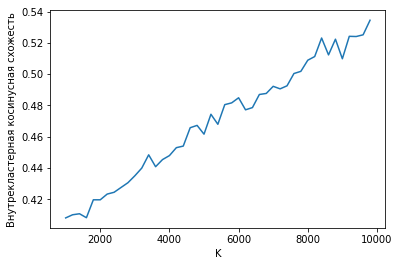

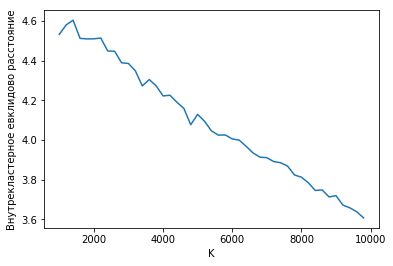

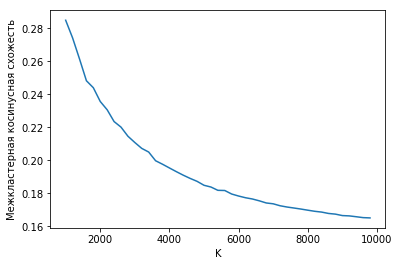

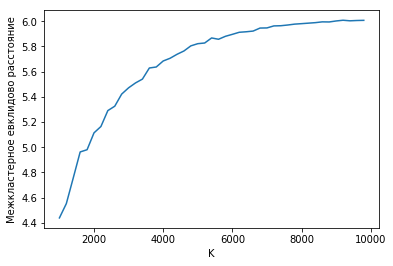

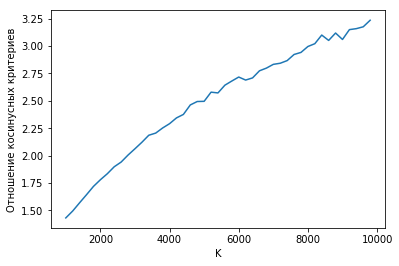

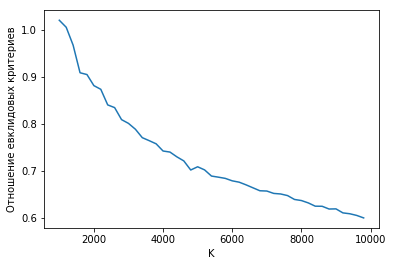

In [80]:
K = np.arange(1000, 10000, 200)
plt.plot(K, ic)
plt.xlabel("K")
plt.ylabel("Внутрекластерная косинусная схожесть")
plt.show()
plt.plot(K, ie)
plt.xlabel("K")
plt.ylabel("Внутрекластерное евклидово расстояние")
plt.show()
plt.plot(K, ec)
plt.xlabel("K")
plt.ylabel("Межкластерная косинусная схожесть")
plt.show()
plt.plot(K, ee)
plt.xlabel("K")
plt.ylabel("Межкластерное евклидово расстояние")
plt.show()
plt.plot(K, iec)
plt.xlabel("K")
plt.ylabel("Отношение косинусных критериев")
plt.show()
plt.plot(K, iee)
plt.xlabel("K")
plt.ylabel("Отношение евклидовых критериев")
plt.show()


По графикам заметно, что где-то в районе К=5000 межкластерные расстояния меняются слабо, таким образом я предполагаю именно К=5000 наиболее оптимальным. Такое число достаточно хорошо соответствует интуитивному представлению, так как это около 4 слов на кластер в среднем. Интересно было бы посмотреть, что из себя представляют такие кластеры:

In [74]:
import random
random.seed()
best = out[20]
for i in range(0,5):
    p = random.randint(i*1000, (i + 1)*1000)
    print("Кластер №", p)
    for j in range(0, len(traindata)):
        if best.labels_[j] == p:
            print(data[-j - 1][0])
    print('\n')


Кластер № 560
parental
grandparents
maternal
fathers
pregnant
generations
relatives
childhood
parents
child
children
family


Кластер № 1750
gratuite
gratuit


Кластер № 2285
htdocs


Кластер № 3237
aussie
outback
australasia
kangaroo
australians
darwin
tasmania
victoria
wales
australian
australia


Кластер № 4560
disasters
disaster




Как можно легко заметить, слова в одном кластере достаточно хорошо связаны по смыслу, а значит в этом плане кластеризация оказалась достаточно успешной. Посмотрим распределение количество слов по кластерам:

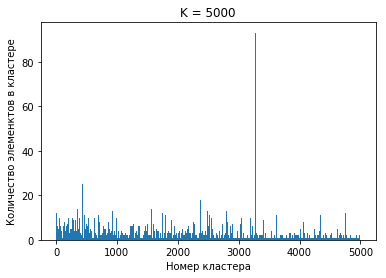

Кластеров с одним элементом: 1732


In [78]:
K = 5000
arr =  out[int((K-1000)/200)].labels_
num = 0
for i in range(0, K):
    if i not in arr:
        num += 1
plt.hist(arr, bins=K, range=(0, K))
plt.title("K = {}".format(K))
plt.xlabel("Номер кластера")
plt.ylabel("Количество элеменктов в кластере")
plt.show()
clust = clusters(out[int((K-1000)/200)], K, traindata)

single = 0
for cluster in clust:
    if len(cluster) == 1:
        single += 1
print("Кластеров с одним элементом:", single)

Видно, что распределение по кластерам достаточно неравномерно: присутствуют кластеры как с большим количеством элементов (до 20), один огромный кластер, в который попало около 90 слов. При этом около трети кластеров состоят всего из одного элемента.

# Итоги

В результате эксперимента можно сказать, что наилучшим К можно считать 5000. Результаты работы самого алгоритма можно оценить как достаточно средние, так как схожесть слов в кластерах следует из того, что данные были очень хорошо предобработаны, а треть кластеров состоят всего из одного элемента.

Далее идут служебные блоки, связанные с сохранением и загрузкой промежуточных результатов. Файлы data.txt, all.pickle и out.pickle так же лежат на Github.

In [23]:
import pickle
with open('out.pickle', 'wb') as f:
    pickle.dump(out, f)

In [21]:
import pickle
with open('out.pickle', 'rb') as f:
    out = pickle.load(f)

In [81]:
with open('all.pickle', 'wb') as f:
    pickle.dump((ic, ie, ec, ee, iec, iee), f)

In [22]:
with open('all.pickle', 'rb') as f:
    ic, ie, ec, ee, iec, iee = pickle.load(f)
    